In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr, confusion_matrix as cm, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import lightgbm as lgb







In [2]:
colors = ['skyblue', 'orange']  # class 0 = skyblue, class 1 = orange

# 1. Load dataset
df = pd.read_csv("../Fraud_dataset.csv")
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [3]:
counts = df['fraud_bool'].value_counts()
majority = counts.max()
minority = counts.min()

imbalance_ratio = majority / minority
print("Majority class:", majority)
print("Minority class:", minority)
print("Imbalance Ratio (IR):", imbalance_ratio)

total = len(df)
minority_pct = (minority / total) * 100
print("Minority class percentage:", minority_pct)

Majority class: 988971
Minority class: 11029
Imbalance Ratio (IR): 89.67005168192946
Minority class percentage: 1.1029


In [4]:
df = df.apply(
    lambda col: col.str.lower() if col.dtype == "object" else col
)


In [5]:
# 2. Separate features and target
X = df.drop(columns=["fraud_bool"])
y = df["fraud_bool"]
print(X.head())
print(y.head())

   income  name_email_similarity  prev_address_months_count  \
0     0.3               0.986506                         -1   
1     0.8               0.617426                         -1   
2     0.8               0.996707                          9   
3     0.6               0.475100                         11   
4     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w   velocity_6h  ...  \
0              102.453711           aa          1059  13096.035018  ...   
1               -0.849551           ad          1658   9

In [6]:
# 3. Identify categorical columns
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Convert categorical columns to numeric category codes for SMOTENC
X_encoded = X.copy()
for col in categorical_cols:
    X_encoded[col] = X_encoded[col].astype("category").cat.codes

X_encoded.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0.3,0.986506,-1,25,40,0.006735,102.453711,0,1059,13096.035018,...,0,1500.0,0,0,16.224843,0,1,1,0,0
1,0.8,0.617426,-1,89,20,0.010095,-0.849551,3,1658,9223.283431,...,0,1500.0,0,0,3.363854,2,1,1,0,0
2,0.8,0.996707,9,14,40,0.012316,-1.490386,1,1095,4471.472149,...,0,200.0,0,0,22.730559,3,0,1,0,0
3,0.6,0.475100,11,14,30,0.006991,-1.863101,1,3483,14431.993621,...,0,200.0,0,0,15.215816,0,1,1,0,0
4,0.9,0.842307,-1,29,40,5.742626,47.152498,0,2339,7601.511579,...,0,200.0,0,0,3.743048,2,0,1,0,0


In [7]:
# 5. Get categorical column indices for SMOTENC
categorical_idx = [X_encoded.columns.get_loc(col) for col in categorical_cols]

# -------------------------------
# 6. TRUE HYBRID SAMPLING
# -------------------------------
# Partial undersampling of majority class
undersampler = RandomUnderSampler(
    sampling_strategy=0.15,   # majority becomes 2× minority
    random_state=42
)

# SMOTENC oversampling for categorical + numeric mixed data
smote_nc = SMOTENC(
    categorical_features=categorical_idx,
    random_state=42,
    sampling_strategy="auto"
)

# Pipeline applies UnderSampling → OverSampling
pipeline = Pipeline([
    ("under", undersampler),
    ("over", smote_nc)
])

X_resampled, y_resampled = pipeline.fit_resample(X_encoded, y)
print(X_resampled[0:3], y_resampled[0:3])

MemoryError: Unable to allocate 928. MiB for an array with shape (11029, 11029) and data type float64

In [ ]:
# -------------------------------
# 7. BEFORE vs AFTER class counts
# -------------------------------
before_counts = y.value_counts()
after_counts = y_resampled.value_counts()

print("Before Hybrid Sampling:\n", before_counts)
print("\nAfter Hybrid Sampling:\n", after_counts)

# -------------------------------
# 8. CALCULATE sampling amounts
# -------------------------------
before_majority = before_counts.max()
before_minority = before_counts.min()

after_majority = after_counts.max()
after_minority = after_counts.min()

# How much undersampling?
undersampled_amount = before_majority - after_majority
undersampled_percent = (undersampled_amount / before_majority) * 100

# How much oversampling?
oversampled_amount = after_minority - before_minority
oversampled_percent = (oversampled_amount / before_minority) * 100

print("\n===== SAMPLING SUMMARY =====")
print(f"Majority BEFORE: {before_majority}")
print(f"Majority AFTER:  {after_majority}")
print(f"Undersampled amount: {undersampled_amount}")
print(f"Undersampled percent: {undersampled_percent:.2f}%\n")

print(f"Minority BEFORE: {before_minority}")
print(f"Minority AFTER:  {after_minority}")
print(f"Oversampled amount: {oversampled_amount}")
print(f"Oversampled percent: {oversampled_percent:.2f}%")


Before Hybrid Sampling:
 0    692280
1      7720
Name: fraud_bool, dtype: int64

After Hybrid Sampling:
 0    51466
1    51466
Name: fraud_bool, dtype: int64

===== SAMPLING SUMMARY =====
Majority BEFORE: 692280
Majority AFTER:  51466
Undersampled amount: 640814
Undersampled percent: 92.57%

Minority BEFORE: 7720
Minority AFTER:  51466
Oversampled amount: 43746
Oversampled percent: 566.66%


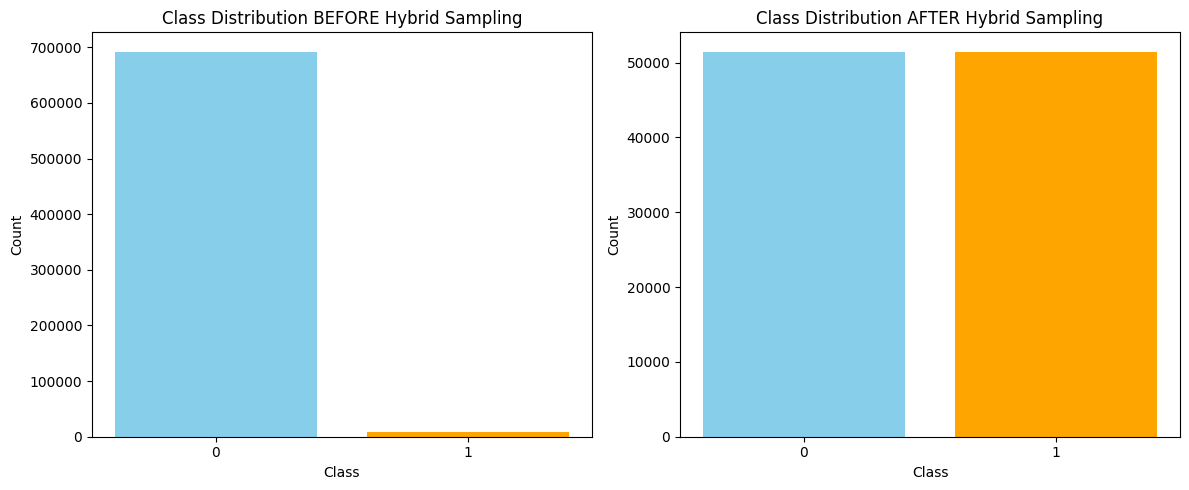

In [ ]:
# -------------------------------
# 9. PLOT class distributions
# -------------------------------
plt.figure(figsize=(12, 5))
# Before sampling
plt.subplot(1, 2, 1)
plt.bar(before_counts.index.astype(str), before_counts.values, color=colors)
plt.title("Class Distribution BEFORE Hybrid Sampling")
plt.xlabel("Class")
plt.ylabel("Count")

# After sampling
plt.subplot(1, 2, 2)
plt.bar(after_counts.index.astype(str), after_counts.values, color=colors)
plt.title("Class Distribution AFTER Hybrid Sampling")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

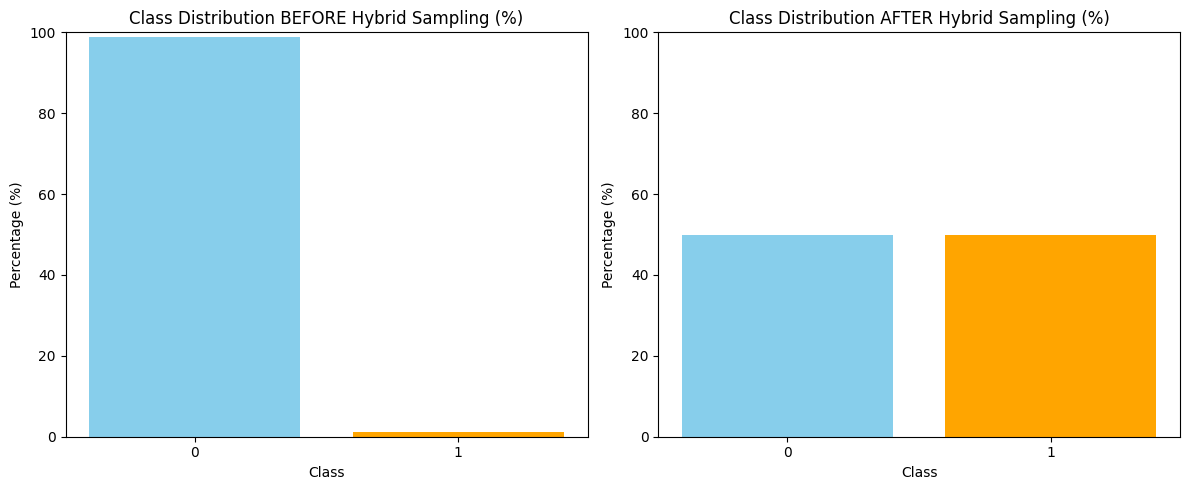

In [ ]:

# -------------------------------
# 10. PLOT class distributions (percentages)
# -------------------------------
before_percent = before_counts / before_counts.sum() * 100
after_percent = after_counts / after_counts.sum() * 100

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(before_percent.index.astype(str), before_percent.values, color=colors)
plt.title("Class Distribution BEFORE Hybrid Sampling (%)")
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)

plt.subplot(1, 2, 2)
plt.bar(after_percent.index.astype(str), after_percent.values, color=colors)
plt.title("Class Distribution AFTER Hybrid Sampling (%)")
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [ ]:
# Combine features and target into a single DataFrame
df_resampled = X_resampled.copy()
df_resampled["fraud_bool"] = y_resampled.values  # add the target column

# Save to CSV
#df_resampled.to_csv("df_resampled.csv", index=False)

In [ ]:
# Missing Value Indicators (batch creation)
# ---------------------------
missing_df_resampled = pd.DataFrame({
    f"{col}_missing": df_resampled[col].isna().astype(int)
    for col in df_resampled.columns
    if df_resampled[col].isna().sum() > 0
})

missing_df_resampled.head()

""


In [ ]:
df_resampled.duplicated().sum()


0

In [ ]:
# Calculate Q1 and Q3 for numeric columns
Q1 = df_resampled.quantile(0.25)
Q3 = df_resampled.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers: True if value < Q1 - 1.5*IQR or > Q3 + 1.5*IQR
outliers = ((df_resampled < (Q1 - 1.5 * IQR)) | (df_resampled > (Q3 + 1.5 * IQR)))

# Count of outliers per column
outliers.sum()




C:\Users\Emma. O.Kyei Mckeow\AppData\Local\Temp\ipykernel_58700\3172826416.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df_resampled.quantile(0.25)
C:\Users\Emma. O.Kyei Mckeow\AppData\Local\Temp\ipykernel_58700\3172826416.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df_resampled.quantile(0.75)
C:\Users\Emma. O.Kyei Mckeow\AppData\Local\Temp\ipykernel_58700\3172826416.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((df_resampled 

bank_branch_count_8w                16512
bank_months_count                       0
credit_risk_score                     124
current_address_months_count         3460
customer_age                          323
date_of_birth_distinct_emails_4w     1742
days_since_request                  15151
device_distinct_emails_8w            4089
device_fraud_count                      0
device_os                               0
email_is_free                           0
employment_status                       0
foreign_request                      1805
fraud_bool                              0
has_other_cards                     12364
housing_status                          0
income                                  0
intended_balcon_amount              22632
keep_alive_session                      0
month                                   0
name_email_similarity                   0
payment_type                            0
phone_home_valid                        0
phone_mobile_valid                

In [ ]:
# Copy to avoid modifying original accidentally
df_cleaned = df_resampled.copy()

cap_cols = [
    'prev_address_months_count', 'current_address_months_count', 'customer_age',
    'days_since_request', 'intended_balcon_amount', 'zip_count_4w',
    'velocity_6h', 'velocity_24h', 'bank_branch_count_8w',
    'date_of_birth_distinct_emails_4w', 'employment_status',
    'credit_risk_score', 'phone_mobile_valid', 'has_other_cards',
    'foreign_request', 'session_length_in_minutes', 'device_distinct_emails_8w'
]


numeric_cols = df_cleaned.select_dtypes(include=np.number).columns
cap_cols_numeric = [col for col in cap_cols if col in numeric_cols]

for col in cap_cols_numeric:
    lower = df_cleaned[col].quantile(0.01)
    upper = df_cleaned[col].quantile(0.99)
    df_cleaned[col] = df_cleaned[col].clip(lower, upper)


In [ ]:
skewed_cols = [
    col for col in df_cleaned.columns
    if df_cleaned[col].dtype != 'O'           # numeric
    and df_cleaned[col].nunique() > 10        # continuous
    and (df_cleaned[col] > 0).all()           # strictly positive
]
log_df = pd.DataFrame({
    f"{col}_log": np.log1p(df_cleaned[col])
    for col in skewed_cols
})


In [ ]:
interaction_pairs = [
    ("velocity_6h", "velocity_24h"),
    ("device_fraud_count", "device_distinct_emails_8w"),
    ("prev_address_months_count", "current_address_months_count"),
]

interaction_dict = {}

for f1, f2 in interaction_pairs:
    if f1 in df_cleaned.columns and f2 in df_cleaned.columns:
        interaction_dict[f"{f1}_x_{f2}"]    = df_cleaned[f1] * df_cleaned[f2]
        interaction_dict[f"{f1}_plus_{f2}"] = df_cleaned[f1] + df_cleaned[f2]
        interaction_dict[f"{f1}_ratio_{f2}"] = df_cleaned[f1] / (df_cleaned[f2] + 1)

interaction_df = pd.DataFrame(interaction_dict)
interaction_df.head()

,velocity_6h_x_velocity_24h,velocity_6h_plus_velocity_24h,velocity_6h_ratio_velocity_24h,device_fraud_count_x_device_distinct_emails_8w,device_fraud_count_plus_device_distinct_emails_8w,device_fraud_count_ratio_device_distinct_emails_8w,prev_address_months_count_x_current_address_months_count,prev_address_months_count_plus_current_address_months_count,prev_address_months_count_ratio_current_address_months_count
0,3.722134e+07,12471.636141,1.521342,0,1,0.0,6555,172,1.982759
1,6.177877e+06,6771.445966,0.191139,0,1,0.0,101,102,50.500000
2,1.624676e+07,8265.248820,1.565899,0,1,0.0,-200,199,-0.004975
3,1.292344e+07,7422.808107,1.660994,0,1,0.0,-247,246,-0.004032
4,2.617052e+06,4043.810580,0.250029,0,1,0.0,-59,58,-0.016667


In [ ]:
df_engineered = pd.concat([df_cleaned, missing_df_resampled, log_df, interaction_df], axis=1)
df_engineered.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,session_length_in_minutes_log,velocity_6h_x_velocity_24h,velocity_6h_plus_velocity_24h,velocity_6h_ratio_velocity_24h,device_fraud_count_x_device_distinct_emails_8w,device_fraud_count_plus_device_distinct_emails_8w,device_fraud_count_ratio_device_distinct_emails_8w,prev_address_months_count_x_current_address_months_count,prev_address_months_count_plus_current_address_months_count,prev_address_months_count_ratio_current_address_months_count
0,0.6,0.897885,115,57,40,6.920375,36.828699,aa,3048.0,7525.811907,...,1.450017,3.722134e+07,12471.636141,1.521342,0,1,0.0,6555,172,1.982759
1,0.9,0.062318,101,1,50,0.014653,-1.219878,ab,2061.0,1086.757397,...,0.577968,6.177877e+06,6771.445966,0.191139,0,1,0.0,101,102,50.500000
2,0.1,0.521946,-1,200,30,0.012651,-1.350405,ab,1032.0,5044.668597,...,1.851716,1.624676e+07,8265.248820,1.565899,0,1,0.0,-200,199,-0.004975
3,0.4,0.507431,-1,247,40,0.038099,-1.559552,ab,969.0,4633.945674,...,2.205221,1.292344e+07,7422.808107,1.660994,0,1,0.0,-247,246,-0.004032
4,0.8,0.245342,-1,59,30,0.029129,-1.434780,ab,997.0,809.037366,...,1.395517,2.617052e+06,4043.810580,0.250029,0,1,0.0,-59,58,-0.016667


In [ ]:
# 4. Train-test split BEFORE any resampling
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

In [ ]:

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

In [ ]:
categorical_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
for col in categorical_cols:
    X_train[col] = X_train[col].astype("category").cat.codes
    X_test[col] = X_test[col].astype("category").cat.codes  # make sure test matches

C:\Users\Emma. O.Kyei Mckeow\AppData\Local\Temp\ipykernel_58700\3765135178.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype("category").cat.codes  # make sure test matches
C:\Users\Emma. O.Kyei Mckeow\AppData\Local\Temp\ipykernel_58700\3765135178.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype("category").cat.codes  # make sure test matches
C:\Users\Emma. O.Kyei Mckeow\AppData\Local\Temp\ipykernel_58700\3765135178.py:4: SettingWithCopy

In [ ]:
# Ensure validation has the same columns as training
missing_cols = [col for col in X_train.columns if col not in X_val_encoded.columns]
for col in missing_cols:
    X_val[col] = 0  # or np.nan if your model handles it

# Reorder columns to match training
X_val = X_val[X_train.columns]


In [ ]:
from lightgbm import early_stopping, log_evaluation

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=200),
        log_evaluation(period=100)  # replaces verbose
    ]
)


[LightGBM] [Info] Number of positive: 51466, number of negative: 51466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8102
[LightGBM] [Info] Number of data points in the train set: 102932, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.867575	valid_0's binary_logloss: 0.157166
[200]	valid_0's auc: 0.881278	valid_0's binary_logloss: 0.173186
[300]	valid_0's auc: 0.88157	valid_0's binary_logloss: 0.166443
Early stopping, best iteration is:
[133]	valid_0's auc: 0.874207	valid_0's binary_logloss: 0.148487


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=500,
               random_state=42, subsample=0.9)

In [ ]:

# Make a copy of test sets
X_test_encoded = X_test.copy()

# Find all object columns
object_cols = X_test_encoded.select_dtypes(include=['object']).columns.tolist()

# Convert all object columns to category codes
for col in object_cols:
    X_test_encoded[col] = X_test_encoded[col].astype('category').cat.codes

In [ ]:
# Ensure test set has the same columns as training set
missing_cols = [col for col in X_train.columns if col not in X_test_encoded.columns]
for col in missing_cols:
    X_test_encoded[col] = 0  # fill missing features with 0

# Reorder columns to match training
X_test_encoded = X_test_encoded[X_train.columns]


In [ ]:
y_pred = lgb_model.predict(X_test_encoded)
y_prob = lgb_model.predict_proba(X_test_encoded)[:, 1]


=== LIGHTGBM CLASSIFICATION REPORT (Threshold = 0.1) ===
              precision    recall  f1-score   support

           0       1.00      0.73      0.84    148345
           1       0.03      0.85      0.06      1655

    accuracy                           0.73    150000
   macro avg       0.52      0.79      0.45    150000
weighted avg       0.99      0.73      0.83    150000



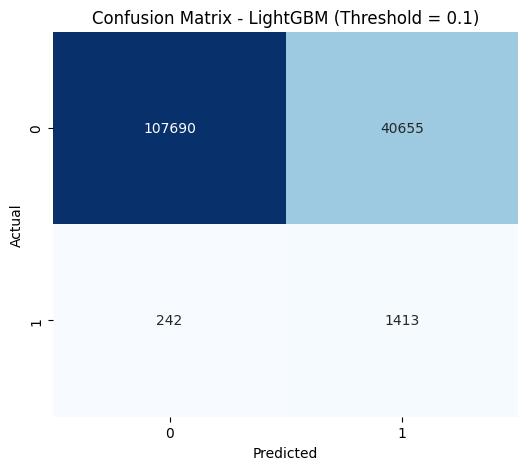


=== ROC-AUC SCORE (Validation Set) ===
0.8742066215166145

=== LIGHTGBM CLASSIFICATION REPORT (Threshold = 0.2) ===
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    148345
           1       0.05      0.70      0.10      1655

    accuracy                           0.86    150000
   macro avg       0.52      0.78      0.51    150000
weighted avg       0.99      0.86      0.91    150000



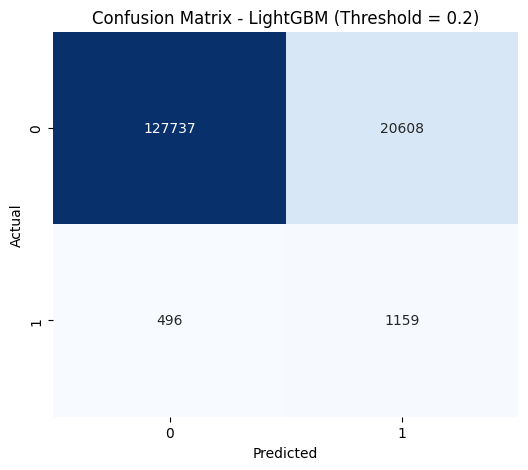


=== ROC-AUC SCORE (Validation Set) ===
0.8742066215166145

=== LIGHTGBM CLASSIFICATION REPORT (Threshold = 0.3) ===
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    148345
           1       0.07      0.60      0.13      1655

    accuracy                           0.91    150000
   macro avg       0.53      0.76      0.54    150000
weighted avg       0.99      0.91      0.94    150000



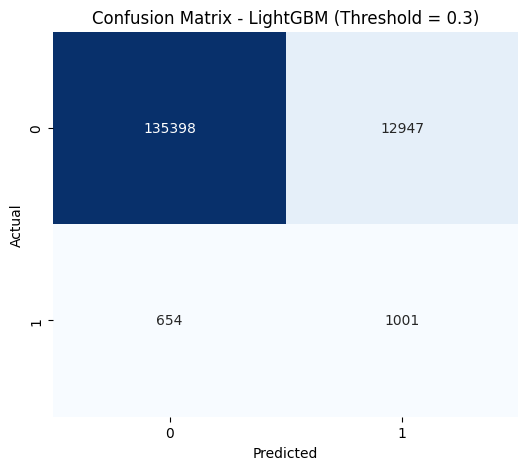


=== ROC-AUC SCORE (Validation Set) ===
0.8742066215166145

=== LIGHTGBM CLASSIFICATION REPORT (Threshold = 0.4) ===
              precision    recall  f1-score   support

           0       0.99      0.94      0.97    148345
           1       0.09      0.52      0.15      1655

    accuracy                           0.94    150000
   macro avg       0.54      0.73      0.56    150000
weighted avg       0.98      0.94      0.96    150000



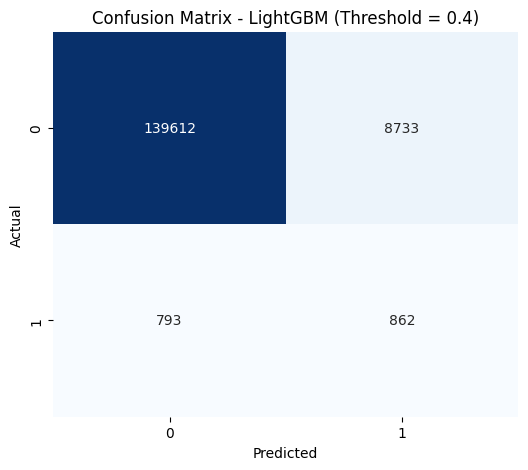


=== ROC-AUC SCORE (Validation Set) ===
0.8742066215166145

=== LIGHTGBM CLASSIFICATION REPORT (Threshold = 0.5) ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    148345
           1       0.11      0.44      0.18      1655

    accuracy                           0.96    150000
   macro avg       0.55      0.70      0.58    150000
weighted avg       0.98      0.96      0.97    150000



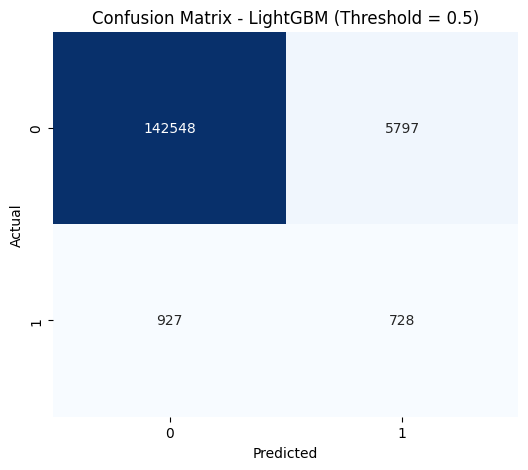


=== ROC-AUC SCORE (Validation Set) ===
0.8742066215166145


In [ ]:
# Get probabilities on validation set (encoded)
y_val_prob = lgb_model.predict_proba(X_val)[:, 1]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

for threshold in thresholds:
    y_val_pred = (y_val_prob >= threshold).astype(int)
    
    print(f"\n=== LIGHTGBM CLASSIFICATION REPORT (Threshold = {threshold}) ===")
    print(cr(y_val, y_val_pred))
    
    cmatrix = cm(y_val, y_val_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - LightGBM (Threshold = {threshold})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(f"\n=== ROC-AUC SCORE (Validation Set) ===")
    print(roc_auc_score(y_val, y_val_prob))


In [ ]:
# Get probabilities on the validation set
y_val_prob = lgb_model.predict_proba(X_val)[:, 1]

# Candidate thresholds from 0.01 to 0.99
thresholds = np.arange(0.01, 1.0, 0.01)

best_threshold = 0.5   # default if no better found
best_f1 = 0

for t in thresholds:
    # Convert probabilities to binary predictions
    y_pred = (y_val_prob >= t).astype(int)
    
    # Compute metrics
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Choose threshold that maximizes F1 (can prioritize recall by custom metric)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# Final evaluation at selected threshold
y_val_pred_final = (y_val_prob >= best_threshold).astype(int)

print(f"Selected Threshold: {best_threshold:.2f}")
print(f"Precision: {precision_score(y_val, y_val_pred_final):.2f}")
print(f"Recall: {recall_score(y_val, y_val_pred_final):.2f}")
print(f"F1-score: {f1_score(y_val, y_val_pred_final):.2f}")




Selected Threshold: 0.67
Precision: 0.16
Recall: 0.29
F1-score: 0.21



=== LIGHTGBM CLASSIFICATION REPORT (Threshold = 0.67) ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    988971
           1       0.15      0.36      0.21     11029

    accuracy                           0.97   1000000
   macro avg       0.57      0.67      0.60   1000000
weighted avg       0.98      0.97      0.98   1000000



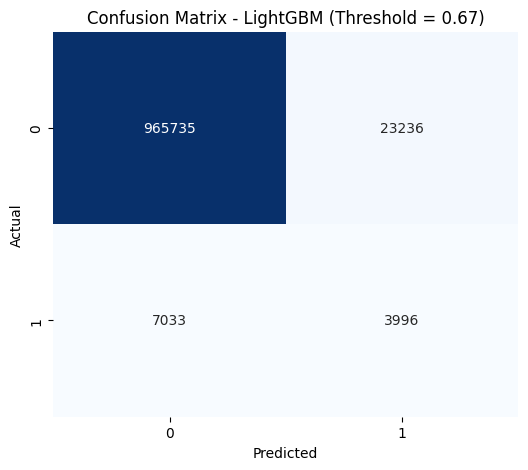


=== ROC-AUC SCORE ===
0.8909


In [ ]:
# -------------------------------
# 1. Ensure test features match training features
X_test_encoded = X_test_encoded.reindex(columns=X_train.columns, fill_value=0)

# -------------------------------
# 2. Generate probabilities
y_prob = lgb_model.predict_proba(X_test_encoded)[:, 1]

# -------------------------------
# 3. Apply threshold
threshold = 0.67
y_pred_final = (y_prob >= threshold).astype(int)

# -------------------------------
# 4. Classification report
print(f"\n=== LIGHTGBM CLASSIFICATION REPORT (Threshold = {threshold}) ===")
print(cr(y_test, y_pred_final))

# -------------------------------
# 5. Confusion matrix
cmatrix = cm(y_test, y_pred_final)
plt.figure(figsize=(6,5))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix - LightGBM (Threshold = {threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# 6. ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\n=== ROC-AUC SCORE ===\n{roc_auc:.4f}")


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)  # optional: calculate PR-AUC


0.1430202732796511


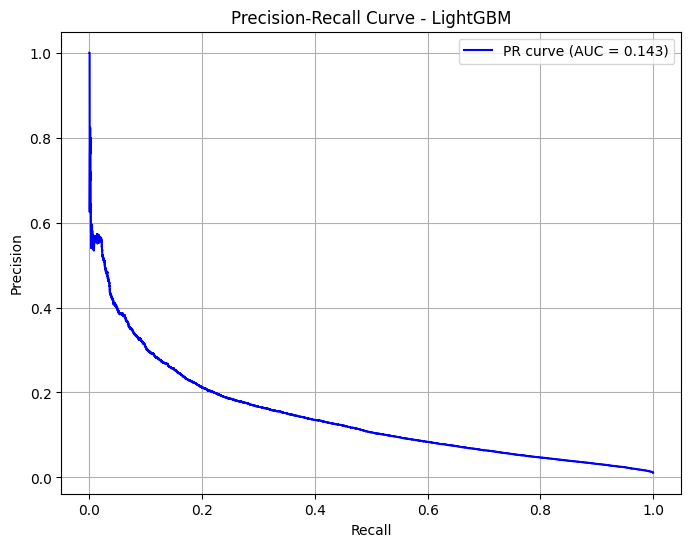

In [ ]:
print(pr_auc)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LightGBM')
plt.legend()
plt.grid(True)
plt.show()